In [1]:
import numpy as np
import pandas as pd
import datetime
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
font_path = 'C:/Windows/Fonts/malgun.ttf'
rc('font', family=fm.FontProperties(fname=font_path).get_name())

## 1. Load data
- I'm using the files that were updated at **April 21st**
- ref : https://github.com/jihoo-kim/Data-Science-for-COVID-19
<br><br>
- datasets
  - Region.csv → Region_sido_addPop_addHospital.csv
  - PatientInfo.csv
  - 흡연율-성-연령별.csv

In [2]:
# Prepare dataset
Region_df = pd.read_csv('../dataset/Region_sido_addPop_addHospital.csv')[['province', 'safe_hospitals_count', 'infection_hospitals_count', 'infection_hospitals_bed_num']]

Smoke_df = pd.read_csv('../dataset/흡연율_성_연령별.csv')
Smoke_df = Smoke_df.rename(columns={'성별':'sex','연령별':'age','분율':'smoking_rate'})
Smoke_df.sex.replace('여성','female',inplace=True)
Smoke_df.sex.replace('남성','male',inplace=True)
Smoke_df = Smoke_df[['sex','age','smoking_rate']]

PatientInfo_df = pd.read_csv('../dataset/Patient/PatientInfo.csv')
PatientInfo_df = pd.merge(PatientInfo_df, Smoke_df, how='left', on=['sex','age'])

print(f'PatientInfo.csv shape : {PatientInfo_df.shape}')

PatientInfo_df = PatientInfo_df[PatientInfo_df.state.isin(['released', 'deceased'])]
print(f'      → datset shape : {PatientInfo_df.shape}')

PatientInfo_df['symptom_onset_date'] = pd.to_datetime(PatientInfo_df['symptom_onset_date'])  # convert data type
PatientInfo_df['confirmed_date'] = pd.to_datetime(PatientInfo_df['confirmed_date'])  # convert data type
PatientInfo_df['disease'] = PatientInfo_df['disease'].astype(float)  # convert data type

display(PatientInfo_df.head(3))


# Save patient_id list
present_patients = PatientInfo_df.patient_id.astype(str).tolist()
with open('patients_id_0421.txt', 'w') as fp:
    fp.write('\n'.join(present_patients))

PatientInfo.csv shape : (3326, 19)
      → datset shape : (1704, 19)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,smoking_rate
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,40.6
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaT,2020-01-30,2020-03-02,NaN,released,39.9
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaT,2020-01-30,2020-02-19,NaN,released,40.6


In [3]:
# Check Null values
PatientInfo_df.contact_number.value_counts(dropna=False, normalize=True) * 100
PatientInfo_df.symptom_onset_date.value_counts(dropna=False, normalize=True) * 100
PatientInfo_df.infection_order.value_counts(dropna=False, normalize=True) * 100
# PatientInfo_df.disease.value_counts(dropna=False, normalize=True) * 100
# PatientInfo_df.country.value_counts(dropna=False, normalize=True) * 100

NaN    98.298122
1.0     0.586854
2.0     0.469484
3.0     0.352113
5.0     0.176056
4.0     0.117371
Name: infection_order, dtype: float64

## 2. Preprocess data
- selected features : **'sex', 'birth_year', 'age', 'province', 'disease (98.9% NaN)', 'infection_case (34.1% NaN)', 'symptom_onset_date (86.2% NaN)', 'confirmed_date', 'contact_number (75.4% NaN)''**
- dropped features after validation : 'country', 'city', 'infection_order (98.3% NaN)
- handling nan
    - drop nan from 'sex' & 'age'
    - replace with mean of same age group in birth_year
    - replace with 'non-reported' in infection_case
    - fill -1 in disease
    - fill -1 in contact_number
    - fill -1 in days_btw_symptom_confirm
- new features : 'years_after_birth', 'days_after_first_date', 'days_btw_symptom_confirm', 'days_after_first_date_province', 'province_safe_hospitals_count', 'province_infection_hospitals_count', 'province_infection_bed_count'
    - (ohter new features were created but deleted after evaluation - 'smoking rate')
- feature encoding (categorical)
    - age : convert to integer (0~10) - label encoding
    - other categorical columns : one-hot encoding

In [4]:
# Select features
X_features = PatientInfo_df[['sex', 'birth_year', 'age', 'province', 'disease', 'infection_case',
                             'symptom_onset_date', 'confirmed_date', 'contact_number']].copy()
y_target = PatientInfo_df[['state']].copy()

print(f'X_features.shape : {X_features.shape}')
print(f'y_target.shape : {y_target.shape}')
X_features.head(3)

X_features.shape : (1704, 9)
y_target.shape : (1704, 1)


,sex,birth_year,age,province,disease,infection_case,symptom_onset_date,confirmed_date,contact_number
0,male,1964.0,50s,Seoul,NaN,overseas inflow,2020-01-22,2020-01-23,75.0
1,male,1987.0,30s,Seoul,NaN,overseas inflow,NaT,2020-01-30,31.0
2,male,1964.0,50s,Seoul,NaN,contact with patient,NaT,2020-01-30,17.0


In [5]:
print('\n<< no of nan table (before handling) >>')
print(X_features.isna().sum())

# Handle nan - sex & age
y_target = y_target[~X_features.sex.isna() & ~X_features.age.isna()]
X_features = X_features[~X_features.sex.isna() & ~X_features.age.isna()]

# Handle nan - birth_year
mean_year_list = dict(X_features.groupby('age')['birth_year'].mean().round().reset_index().values)
X_features.loc[X_features.birth_year.isna(), 'birth_year'] = X_features.loc[X_features.birth_year.isna(), 'age'].map( lambda x : mean_year_list[ x ] )

# Handle nan - infection_case
X_features.loc[X_features.infection_case.isna(), 'infection_case'] = 'not-reported'

# Handle nan - disease, contact_number
X_features.disease = X_features.disease.fillna(-1)
X_features.contact_number = X_features.contact_number.fillna(-1)


print('\n<< no of nan table (after handling) >>')
print(X_features.isna().sum())


print(f'\n\nX_features.shape : {X_features.shape}')
print(f'y_target.shape : {y_target.shape}')


<< no of nan table (before handling) >>
sex                      7
birth_year             224
age                     10
province                 0
disease               1686
infection_case         582
symptom_onset_date    1469
confirmed_date           0
contact_number        1285
dtype: int64

<< no of nan table (after handling) >>
sex                      0
birth_year               0
age                      0
province                 0
disease                  0
infection_case           0
symptom_onset_date    1459
confirmed_date           0
contact_number           0
dtype: int64


X_features.shape : (1694, 9)
y_target.shape : (1694, 1)


In [6]:
# Create new features
X_features['years_after_birth'] = datetime.date.today().year - X_features['birth_year']

X_features['days_after_first_date'] = X_features['confirmed_date'] - X_features['confirmed_date'].min()
X_features['days_after_first_date'] = X_features['days_after_first_date'].dt.days

X_features['days_btw_symptom_confirm'] = (X_features['confirmed_date'] - X_features['symptom_onset_date']).dt.days
X_features['days_btw_symptom_confirm'] = X_features['days_btw_symptom_confirm'].fillna(-1)  # Handle nan

# deleted after evaluation - days_after_first_date_province
first_date_province_dict = dict(PatientInfo_df.groupby('province')['confirmed_date'].min().reset_index().values)
X_features['first_date_province'] = X_features['province'].map( lambda x : first_date_province_dict[x] )
X_features['days_after_first_date_province'] = X_features['confirmed_date'] - X_features['first_date_province']
X_features['days_after_first_date_province'] = X_features['days_after_first_date_province'].dt.days

# deleted after evaluation - province infomations
province_info_dict = { item_list[0]:item_list[1:] for item_list in Region_df.values }
X_features['province_safe_hospitals_count'] = X_features.province.map(lambda x : province_info_dict[x][0])
X_features['province_infection_hospitals_count'] = X_features.province.map(lambda x : province_info_dict[x][1])
X_features['province_infection_bed_count'] = X_features.province.map(lambda x : province_info_dict[x][2])

X_features = X_features.drop(columns=['birth_year', 'symptom_onset_date', 'confirmed_date', 'first_date_province'])

X_features.head(3)

,sex,age,province,disease,infection_case,contact_number,years_after_birth,days_after_first_date,days_btw_symptom_confirm,days_after_first_date_province,province_safe_hospitals_count,province_infection_hospitals_count,province_infection_bed_count
0,male,50s,Seoul,-1.0,overseas inflow,75.0,56.0,3,1.0,0,67,5,2535
1,male,30s,Seoul,-1.0,overseas inflow,31.0,33.0,10,-1.0,7,67,5,2535
2,male,50s,Seoul,-1.0,contact with patient,17.0,56.0,10,-1.0,7,67,5,2535


In [7]:
# feature encoding - X_features
X_features_processed = X_features.copy()
X_features_processed = pd.concat([X_features_processed, pd.get_dummies(X_features_processed[['sex', 'province', 'infection_case']])], 
                                 axis=1)  # one-hot encoding
X_features_processed = X_features_processed.drop(columns=['sex', 'province', 'infection_case'])
X_features_processed['age'] = X_features.age.str.replace('s','').astype(int)//10  # label encoding

display(X_features_processed.head(3))
print()


# feature encoding - y_target
y_target_processed = pd.get_dummies(y_target)['state_deceased']
display(y_target_processed.head(3))

,age,disease,contact_number,years_after_birth,days_after_first_date,days_btw_symptom_confirm,days_after_first_date_province,province_safe_hospitals_count,province_infection_hospitals_count,province_infection_bed_count,...,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_not-reported,infection_case_overseas inflow
0,5,-1.0,75.0,56.0,3,1.0,0,67,5,2535,...,0,0,0,0,0,0,0,0,0,1
1,3,-1.0,31.0,33.0,10,-1.0,7,67,5,2535,...,0,0,0,0,0,0,0,0,0,1
2,5,-1.0,17.0,56.0,10,-1.0,7,67,5,2535,...,0,0,0,0,1,0,0,0,0,0


0    0
1    0
2    0
Name: state_deceased, dtype: uint8

## 3. Split data into train, val, test
- It's important that **labels are highly unbalanced** (only about 3% is deceased)
- Since the dataset is quite small(1704 records), I will split the date into **6:2:2** for now (test data could be added from the next file update)
- Since the labels are highly imbalanced, it's better to use **stratified random sampling**.

In [8]:
# Get train dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X_features_processed, y_target_processed, test_size=0.2, 
                                                            random_state=0, stratify=y_target_processed)

# Get val & test dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.33, random_state=0, stratify=y_train_val)


# Check the labels of each dataset
print('< Percentage of each label (whole dataset) >')
print(y_target_processed.value_counts(normalize=True) * 100)

print('\n< Percentage of each label (Train dataset) > - size of dataset :', y_train.shape[0])
print(y_train.value_counts(normalize=True) * 100)

print('\n< Percentage of each label (Validation dataset) > - size of dataset :', y_val.shape[0])
print(y_val.value_counts(normalize=True) * 100)

print('\n< Percentage of each label (Test dataset) > - size of dataset :', y_test.shape[0])
print(y_test.value_counts(normalize=True) * 100)

< Percentage of each label (whole dataset) >
0    96.044864
1     3.955136
Name: state_deceased, dtype: float64

< Percentage of each label (Train dataset) > - size of dataset : 907
0    96.030871
1     3.969129
Name: state_deceased, dtype: float64

< Percentage of each label (Validation dataset) > - size of dataset : 448
0    95.982143
1     4.017857
Name: state_deceased, dtype: float64

< Percentage of each label (Test dataset) > - size of dataset : 339
0    96.165192
1     3.834808
Name: state_deceased, dtype: float64


## 4. Train model - XGBoost with best hyper-parameter

In [9]:
# Train final model
xgb_final = XGBClassifier(random_state=0, n_jobs=-1, 
                          n_estimators=100, colsample_bytree=0.8, gamma=2, 
                          max_depth=6, min_child_weight=1, subsample=0.6)
xgb_final.fit(X_train_val, y_train_val)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

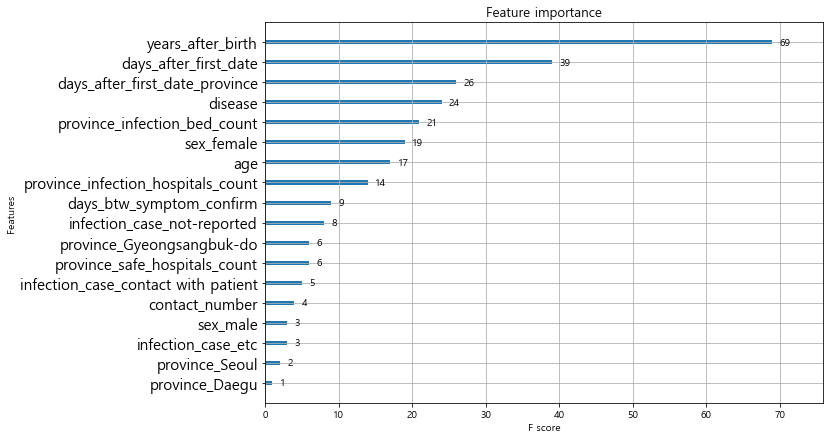

In [10]:
# Visualize the feature importance
fig, ax = plt.subplots(figsize=(10, 7))
plot_importance(xgb_final, ax=ax)
ax.set_title('Feature importance', size=13)
ax.tick_params(axis='y', labelsize=15)

plt.show()

## 5. Test final model

In [11]:
# Evaluate final model
def get_clf_eval(y_test , pred):
    from sklearn.metrics import confusion_matrix, accuracy_score
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import f1_score, roc_auc_score

    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    pass

xgb_preds = xgb_final.predict(X_test)
get_clf_eval(y_test , xgb_preds)

오차 행렬
[[324   2]
 [  5   8]]
정확도: 0.9794, 정밀도: 0.8000, 재현율: 0.6154,    F1: 0.6957, AUC:0.8046
